In [6]:
import numpy as np
import scipy.stats as scp 

We have 

$$\left\lbrace\begin{array}{l}
d_1 = \frac{1}{\sigma\sqrt{\tau}}(ln(\frac{S}{K} + (r+\frac{\sigma^2}{2})\tau) \\[.1cm]
d_2= \frac{1}{\sigma\sqrt{\tau}}(ln(\frac{S}{K} + (r+\frac{\sigma^2}{2})\tau)
\end{array}\right.$$

with $\tau = T - t$

Noticed that $d_2 = d_1 - \sigma\sqrt{\tau}$

In [7]:
def d(S_, K_, r_,sigma_ ,tau_):
    d1_ = 1 / (sigma_ * np.sqrt(tau_)) * ( np.log(S_/K_) + (r_ + sigma_**2/2) * tau_)
    d2_ = d1_ - sigma_ * np.sqrt(tau_)
    return d1_, d2_

We have
$$\boxed{v(\sigma) = S\phi(d_1) - Ke^{-r\tau}\phi(d_2)}$$

with
$$\phi(x) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-\frac{u^2}{2}}du$$

In [8]:
def call_option(S_, K_, r_,sigma_ ,tau_ ,d1_,d2_):
    return scp.norm.cdf(d1_) * S_ - scp.norm.cdf(d2_) * K_ * np.exp(-r_ *tau_)

We define the option's Vega by :
$$\boxed{g'(\sigma) = S\psi(d_1)\sqrt{\tau}}$$

where
$$\left\lbrace\begin{array}{l}
g(\sigma) = v(\sigma) - v^{mkt} \\[.1cm]
\psi(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}\\
d_1 = \frac{1}{\sigma\sqrt{\tau}}(ln(\frac{S}{K} + (r+\frac{\sigma^2}{2})\tau)
\end{array}\right.$$


In [9]:
def call_vega(S_, tau_ , d1_):
    return S_ * scp.norm.pdf(d1_) * np.sqrt(tau_)

Newton-Raphson's method :

$$\sigma_{n+1}=\sigma_n - \frac{g(\sigma)}{g'(\sigma)}$$

or

$$\boxed{\sigma_{n+1}= \sigma_n - \frac{v(\sigma)-v^{mkt}}{S\psi(d_1)}\sqrt{\tau}}$$

In [10]:
def Newton_Raphson(S_,K_,r_,tau_, sigma0_ ,price_, epsilon_):
    d1_,d2_ = d(S_, K_, r_,sigma0_ ,tau_)
    g = call_option(S_, K_, r_,sigma0_ ,tau_,d1_,d2_)-price_
    sigma_ = sigma0_ - g/call_vega(S_,tau_, d1_)
    while np.abs(sigma_-sigma0_)/sigma0_ > epsilon_:
        sigma0_ = sigma_
        d1_,d2_ = d(S_, K_, r_,sigma0_ ,tau_)
        g = call_option(S_, K_, r_,sigma0_ ,tau_,d1_,d2_)-price_
        sigma_ = sigma0_ - g/call_vega(S_,tau_, d1_)
    return sigma_


In [11]:
Newton_Raphson(194.11,210,0.01,60/365,0.5,1.50,1e-6)

0.20015597622419934

Brent's method : 

$$\boxed{ \sigma_{n+1} = \frac{\sigma_ng(\sigma_{n-1})g(\sigma_{n-2})}{(g(\sigma_{n})-g(\sigma_{n-1}))(g(\sigma_{n})-g(\sigma_{n-2}))} + \frac{\sigma_{n-1}g(\sigma_{n-2})g(\sigma_{n})}{(g(\sigma_{n-1})-g(\sigma_{n}))(g(\sigma_{n-1})-g(\sigma_{n-2}))} + \frac{\sigma_{n-2}g(\sigma_{n-1})g(\sigma_{n})}{(g(\sigma_{n-2})-g(\sigma_{n}))(g(\sigma_{n-2})-g(\sigma_{n-2}))}}$$

if $\sigma_n = \sigma_{n-1}$ :

$$\boxed{\sigma_{n+1} = \sigma_{n-1}\frac{\sigma_{n-1}-\sigma_{n-2}}{g(\sigma_{n-1})-g(\sigma_{n-2})}}$$

In [20]:
def Brent(S_,K_,r_,tau_, sigma0_,sigma1_,sigma2_ ,price_, epsilon_):
    volatility = [sigma0_,sigma1_,sigma2_]
    g = []
    d1_,d2_ = d(S_, K_, r_,sigma0_ ,tau_)
    g.append(call_option(S_, K_, r_,sigma0_ ,tau_,d1_,d2_)-price_)
    d1_,d2_ = d(S_, K_, r_,sigma1_ ,tau_)
    g.append(call_option(S_, K_, r_,sigma1_ ,tau_,d1_,d2_)-price_)
    d1_,d2_ = d(S_, K_, r_,sigma2_ ,tau_)
    g.append(call_option(S_, K_, r_,sigma2_ ,tau_,d1_,d2_)-price_)
    i=2
    while ((np.abs(volatility[i]-volatility[i-1]) > epsilon_) & (np.abs(volatility[i-1]-volatility[i-2]) > epsilon_)) :
        if (volatility[i]==volatility[i-1]):
            sigma_ = volatility[i-1]-g[i-1]*(volatility[i-1]-volatility[i-2])/(g[i-1]-g[i-2])
        else :
            aux0_ = volatility[i]*g[i-1]*g[i-2]/((g[i]-g[i-1])*(g[i]-g[i-2]))
            aux1_ = volatility[i-1]*g[i-2]*g[i]/((g[i-1]-g[i-2])*(g[i-1]-g[i]))
            aux2_ = volatility[i-2]*g[i-1]*g[i]/((g[i-2]-g[i-1])*(g[i-2]-g[i]))
            sigma_ = aux0_ + aux1_ + aux2_
        volatility.append(sigma_)
        i=i+1
        d1_,d2_ = d(S_, K_, r_,volatility[i] ,tau_)
        g.append(call_option(S_, K_, r_,volatility[i] ,tau_,d1_,d2_)-price_)
    return volatility
    

In [19]:
Brent(194.11,210,0.01,60/365,0.5,0.45,0.45,1.50,1e-6)

[0.5, 0.45, 0.45]

Choice of $\sigma_0$

We consider 
$$\phi(x) \approx \frac{1}{2} + \frac{1}{\sqrt{2\pi}}x $$

We got $C \approx S_0 (\frac{1}{2} + \frac{1}{\sqrt{2\pi}}d_1) - Ke^{-r\tau}(\frac{1}{2} + \frac{1}{\sqrt{2\pi}}d_2)$

$C = 0 \Longleftrightarrow a\sigma^2 + b\sigma + c =0$

with

$$\left\lbrace\begin{array}{l}
a = S_0 + Ke^{-r\tau} \\[.1cm]
b = \sqrt{2\pi\tau}(S_0-Ke^{-r\tau}) \\[.1cm]
c = (S_0 - Ke^{-r\tau}) ( 2ln(\frac{s_0}{K})+2r\tau )
\end{array}\right.$$

Heston's model :
$$\boxed{C = SP_1 - Ke^{-r\tau}P_2}$$
with
$$P_j = \frac{1}{2} + \frac{1}{\pi}\int_0^{+\infty}Re[\frac{e^{-i\phi ln(K)}f_j}{i\phi}]d\phi$$

In [1]:
from numpy import meshgrid, sqrt, diff
from scipy import inf, pi, exp, linspace, zeros, real, imag, array, log
from scipy.stats import norm
from scipy.integrate import quad
# from bsm import bsmprice


def heston_phi(k, tau, v, vbar, lambd, eta, rho ):    
    b = lambd + 1j*rho*eta*k
    d = sqrt( b**2 + (eta**2)*k*(k-1j) )
    g = (b - d)/(b + d)
    T_m = (b - d)/(eta**2)
    T = T_m * ( 1 - exp(-d*tau) )/( 1 - g*exp(-d*tau) )
    W = lambd * vbar * ( tau*T_m - 2*log( ( 1 - g*exp(-d*tau) )/( 1 - g ) )/(eta**2) )
    return exp(W + v*T)

def heston_phi_transform(tau, x, v, vbar, lambd, eta, rho):
    integrand = lambda k: 2 * real( exp(-1j*k*x) * heston_phi(k + 0.5*1j, tau, v, vbar, lambd, eta, rho) )/(k**2 + 1.0/4.0)
    return quad(integrand, 0, 50)[0]


def heston_ucall(F, K, tau, v, vbar, lambd, eta, rho):
    '''Heston call'''
    x = log(F/K)
    return F - (sqrt(K*F)/(2*pi)) * heston_phi_transform(tau, x, v, vbar, lambd, eta, rho)


def heston_call(S, K, tau, r, q, v, vbar, lambd, eta, rho):
    '''Heston call'''
    F = S*exp((r-q)*tau)
    x = log(F/K)
    integral = heston_phi_transform(tau, x, v, vbar, lambd, eta, rho)
    return S * exp(-q*tau) - K * exp(-r*tau) * integral


$P_1 = e^{-q\tau} \approx \phi(d_1) \Rightarrow q \approx 37.68$  
$err = 6.3e-05$

In [176]:
scp.norm.cdf(d(194.11,210,0.01,0.5,60/365)[0])-191.11*np.exp(-37.68*60/365)

6.279239385492685e-05

$P_2 \approx \phi(d_2) \Rightarrow v=1, vbar =1, lambd = 1, eta = 1, rho = 1$  
$err = 0.044$

In [186]:
scp.norm.cdf(d(194.11,210,0.01,0.5,60/365)[1]) - heston_phi_transform(60/365,np.log(191.11*np.exp(-37.68*60/365)/210),0,1,1,1,1)

0.04428906017774675

$C = SP_1 - Ke^{-r\tau}P_2 = S(\phi(d_1) + err_1) - Ke^{-r\tau}(\phi(d_2)+err_2)$
$$ C = call_{BS} + S err_1 - Ke^{-r\tau}err_2 $$

In [187]:
heston_call(194.11,210,60/365,0.01,37.68,1,1,1,1,1)

-56.87701833438535

In [188]:
d(194.11,210,0.01,0.5,60/365)[0]
call_option(194.11,210,0.01,0.5,60/365,d(194.11,210,0.01,0.5,60/365)[0],d(194.11,210,0.01,0.5,60/365)[1])

9.684892969194578

On a $$ S err_1 - K e^{-r\tau} err_2 = -66.32 $$

In [189]:
194.11*(scp.norm.cdf(d(194.11,210,0.01,0.5,60/365)[0])-191.11*np.exp(-37.68*60/365))-210*np.exp(-0.01*60/365)*scp.norm.cdf(d(194.11,210,0.01,0.5,60/365)[1]) - heston_phi_transform(60/365,np.log(191.11*np.exp(-37.68*60/365)/210),0,1,1,1,1)

-66.32557354732309

In [190]:
heston_call(194.11,210,60/365,0.01,37.68,1,1,1,1,1)-call_option(194.11,210,0.01,0.5,60/365,d(194.11,210,0.01,0.5,60/365)[0],d(194.11,210,0.01,0.5,60/365)[1])

-66.56191130357993

On a $$ C - call_{BS} = -66.56 \approx S err_1 - K e^{-r\tau} err_2 $$
MODELE VALIDE

## Heston model (cours)

In [57]:
from scipy import integrate
import numpy as np

In [58]:
def phi(u,kappa_,S0_,r_,tau_,theta_,rho_,sigma_,V0_):
    gamma_ = np.sqrt((sigma_**2)*(u**2+u*1j)+(kappa_-1j*rho_*sigma_*u)**2)
    a = 1j*u*np.log(S0_) + 1j*u*r_*tau_+kappa_*theta_*tau_*(kappa_-1j*rho_*sigma_*u)/(sigma_**2)
    b = (u**2+1j*u)*V0_/(gamma_*np.cosh(gamma_*tau_/2)+kappa_-1j*rho_*sigma_*u)
    c = np.cosh(gamma_*tau_/2)+((kappa_+1j*rho_*sigma_*u)/gamma_)*np.sinh(gamma_*tau_/2)
    d = 2*kappa_*theta_/(sigma_**2)
    return np.exp(a)*np.exp(-b)/(c**d)

In [61]:
phi(1-1j*2,2,100,0.03,0.5,0.04,-0.7,0.5,0.04)

(47.331413541304414-11977.695000151214j)

On va prendre $\alpha = 1$ pour le calcul de C

In [64]:
def psi(nu_,alpha_,K_,r_,tau_,kappa_,S0_,theta_,rho_,sigma_,V0_):
    k_ = np.log(K_)
    F = phi(nu_-1j*(alpha_+1),kappa_,S0_,r_,tau_,theta_,rho_,sigma_,V0_)*np.exp(-1j*nu_*k_)
    d = (alpha_+1j*nu_)*(alpha_+1+1j*nu_)
    return np.exp(-r_*tau_-alpha_*k_)/np.pi*(F/d).real

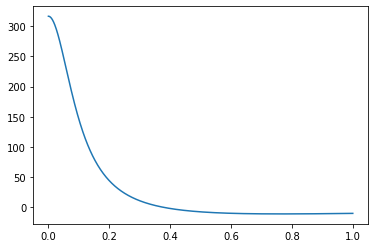

In [82]:
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 1000)
plt.plot(x,psi(x,0.1,90,0.03,0.5,2,100,0.04,-0.7,0.5,0.04))
plt.show()

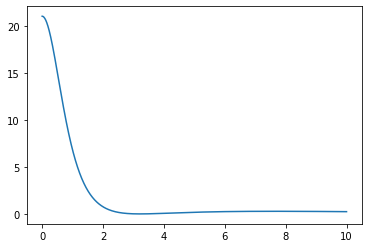

In [72]:
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 1000)
plt.plot(x,psi(x,1,90,0.03,0.5,2,100,0.04,-0.7,0.5,0.04))
plt.show()

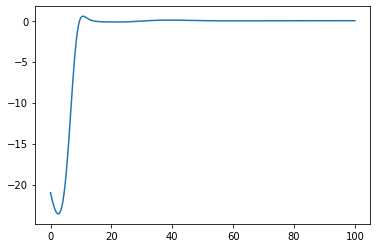

In [85]:
import matplotlib.pyplot as plt

x = np.linspace(0, 100, 1000)
plt.plot(x,psi(x,20,90,0.03,0.5,2,100,0.04,-0.7,0.5,0.04))
plt.show()

In [65]:
psi(1,1,90,0.03,0.5,2,100,0.04,-0.7,0.5,0.04)

6.765506621464055

In [73]:
import scipy as scp

def C(K_,alpha_,r_,tau_,kappa_,S0_,theta_,rho_,sigma_,V0_,L_):
    I = scp.integrate.quad(lambda nu_: psi(nu_,alpha_,K_,r_,tau_,kappa_,S0_,theta_,rho_,sigma_,V0_) , 0, L_)
    return I[0]

In [87]:
C(90,1,0.03,0.5,2,100,0.04,-0.7,0.5,0.04,50)

19.908821955436967